In [2]:
!pip install stumpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 KB 5.2 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 16.9 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 16.6 MB/s eta 0:00:00m eta 0:00:010:00:01


In [16]:
from __future__ import division
import pandas as pd
import numpy as np
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

import stumpy

In [17]:
data_path = "../data/open_vag/normal/novag1"
normal_dir = "../data/open_vag/normal/"
pathology_dir = "../data/open_vag/pathology/"

normal_vag_subjects = [] # 51
pathology_vag_subjects = [] # 38

# read all the files in the normal folder
novag_base_f = "novag"
ab_base_f  = "abvag"

# read normal files
for i, filename in enumerate(os.listdir(normal_dir)):
    file_path = os.path.join(normal_dir, f"{novag_base_f}{i+1}")
    # Open the file for reading
    with open(file_path, 'r') as file:
        # Read all the floating-point numbers into a list
        vags = [float(x) for x in file.read().split()]
        normal_vag_subjects.append(vags)
        
# read pathology files
for i, filename in enumerate(os.listdir(pathology_dir)):
    file_path = os.path.join(pathology_dir, f"{ab_base_f}{i+1}")
    # Open the file for reading
    with open(file_path, 'r') as file:
        # Read all the floating-point numbers into a list
        p_vags = [float(x) for x in file.read().split()]
        pathology_vag_subjects.append(p_vags)

print(f"{len(normal_vag_subjects)} normal subjects")
print(f"{len(pathology_vag_subjects)} pathology subjects")

51 normal subjects
38 pathology subjects


In [80]:
# amplitude normalisation - move to utils
def amplitude_normal(signal):
    sig = np.array(signal)
    data_min = min(sig)
    data_max = max(sig)
    normal = (sig - data_min) / (data_max - data_min)
    return normal.tolist()
    
fs = 2000
n_norm = []
p_norm = []
n_norm_res = []
p_norm_res = []

n_l = 8192  # next fft points value int(math.pow(2, math.ceil(math.log2(len(data)))))

for d_set in normal_vag_subjects:
    n = amplitude_normal(d_set)
    t = np.linspace(0, fs, num=len(n))  # Original x values (e.g., time or sample indices)
    x_new = np.linspace(t.min(), t.max(), n_l)
    
    # Create an interpolation function
    interpolator = interp1d(t, n, kind='linear')
    y_new = interpolator(x_new)
    
    n_norm_res.append(y_new)
    n_norm.append(n)

for d_set in pathology_vag_subjects:
    p = amplitude_normal(d_set)
    #p_res = resample(p, 8192)
    t = np.linspace(0, fs, num=len(p))  # Original x values (e.g., time or sample indices)
    x_new = np.linspace(t.min(), t.max(), n_l)
    
    # Create an interpolation function
    interpolator = interp1d(t, p, kind='linear')
    
    # Apply interpolation to get the new y values
    y_new = interpolator(x_new)
    p_norm_res.append(y_new)
    p_norm.append(p)

# matrix profiling library
https://github.com/TDAmeritrade/stumpy

At its core, the STUMPY library efficiently computes something called a matrix profile, a vector that stores the z-normalized Euclidean distance between any subsequence within a time series and its nearest neighbor.


In [94]:
# data: n_norm = [] p_norm = [] n_norm_res = [] p_norm_res = []

m = 500 # 10 samples 5ms
n_mp = stumpy.stump(n_norm[3], m)
n_motif_idx = np.argsort(n_mp[:, 0])[0]
n_mot_idx_2 = np.argsort(n_mp[:, 0])[1]
n_nearest_neighbor_idx = mp[n_motif_idx, 1]
n_discord_idx = np.argsort(n_mp[:, 0])[-1]
n_nearest_neighbor_distance = n_mp[n_discord_idx, 0]

p_mp = stumpy.stump(p_norm[3], m)
p_motif_idx = np.argsort(p_mp[:,0])[0]
p_nearest_neighbor_idx = mp[p_motif_idx, 1]
p_discord_idx = np.argsort(p_mp[:, 0])[-1]
p_nearest_neighbor_distance = p_mp[p_discord_idx, 0]

print(f"The n motif is located at index {n_motif_idx/fs}")
print(f"The p motif is located at index {p_motif_idx/fs}")

print(n_discord_idx2, n_discord_idx)

The n motif is located at index 0.4725
The p motif is located at index 0.0
2213 2211


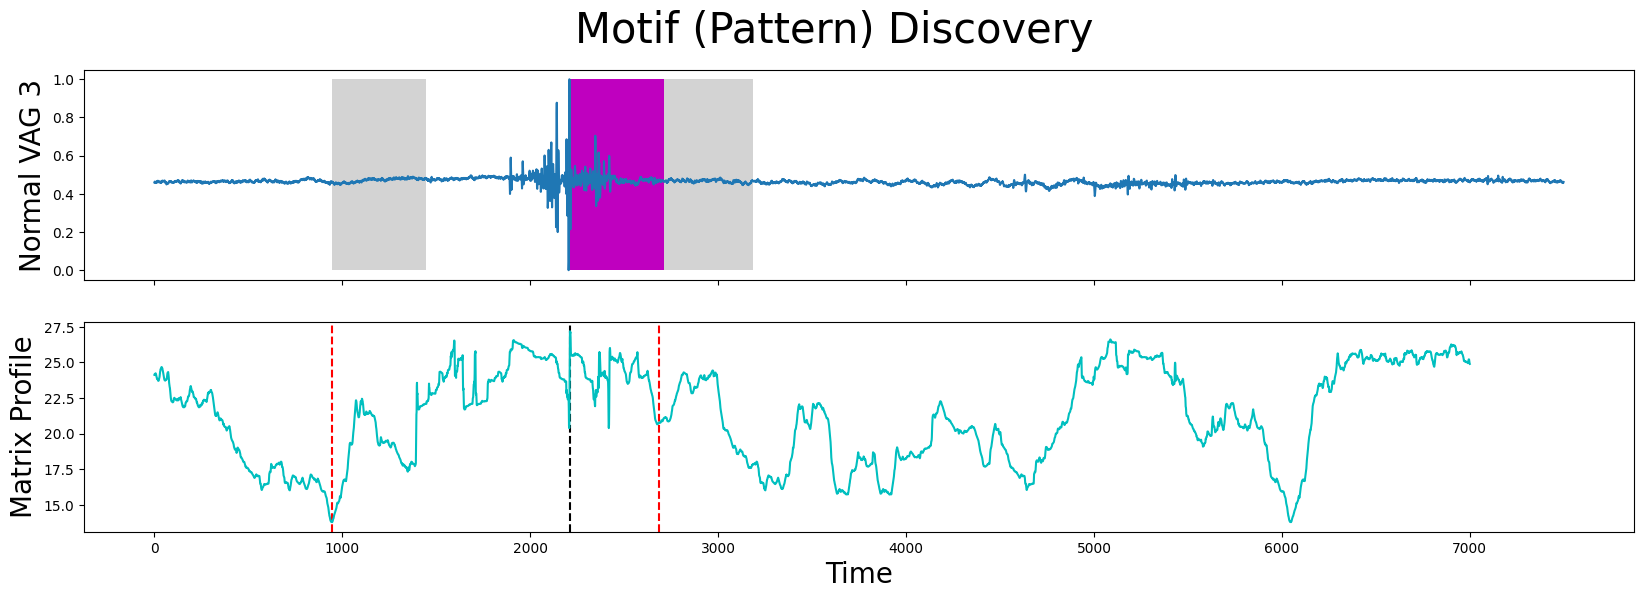

In [96]:
fig, axs = plt.subplots(2, sharex=True)
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(n_norm[3])
#axs[0].plot( np.argsort(n_mp[:,0]), color="pink")
axs[0].set_ylabel('Normal VAG 3', fontsize='20')
rect = Rectangle((n_motif_idx, 0), m, 1, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((n_nearest_neighbor_idx, 0), m, 1, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((n_discord_idx, 0), m, 1, facecolor='m')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=n_motif_idx, linestyle="dashed", color='r')
axs[1].axvline(x=n_nearest_neighbor_idx, linestyle="dashed", color='r')
axs[1].axvline(x=n_discord_idx, linestyle="dashed", color="black")
axs[1].plot(n_mp[:, 0],color="c")
plt.show()

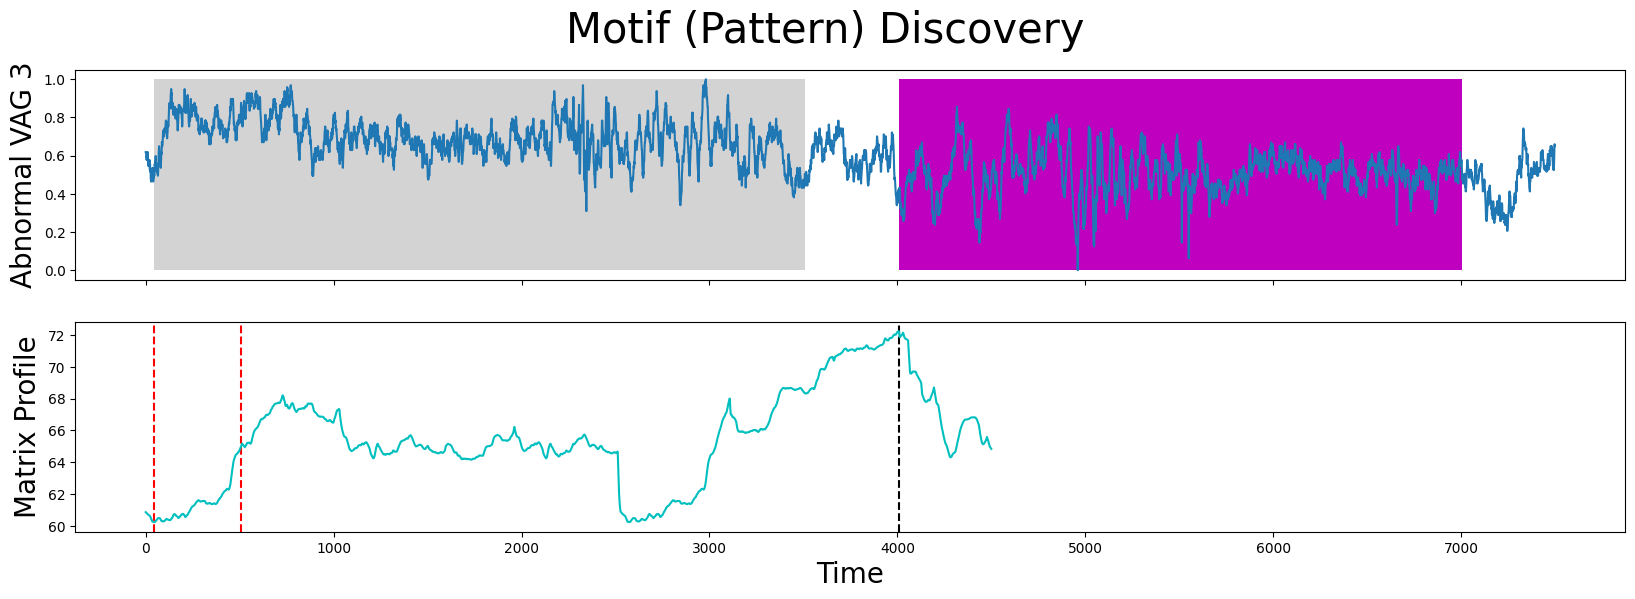

In [86]:
fig, axs = plt.subplots(2, sharex=True)
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(p_norm[3])
axs[0].set_ylabel('Abnormal VAG 3', fontsize='20')
rect = Rectangle((p_motif_idx, 0), m, 1, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((p_nearest_neighbor_idx, 0), m, 1, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((p_discord_idx, 0), m, 1, facecolor='m')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=p_motif_idx, linestyle="dashed", color='r')
axs[1].axvline(x=p_nearest_neighbor_idx, linestyle="dashed", color='r')
axs[1].axvline(x=p_discord_idx, linestyle="dashed", color="black")
axs[1].plot(p_mp[:, 0],color="c")
plt.show()